# Fit independent TTVs

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy.optimize as op
import scipy.signal as sig
from   scipy import stats
from   scipy import fftpack
from   scipy import ndimage
import astropy
from   astropy.io import fits as pyfits

import csv
import sys
import os
import importlib as imp
import glob
from   timeit import default_timer as timer
import warnings
import progressbar
import argparse
import json

import lightkurve as lk
import exoplanet as exo
import theano.tensor as T
import pymc3 as pm
import corner

from alderaan.constants import *
from alderaan.utils import *
from alderaan.Planet import *
from alderaan.LiteCurve import *
import alderaan.io as io
import alderaan.detrend as detrend
import alderaan.noise as noise
from alderaan.omc import omc_model
from alderaan.omc import choose_omc_model


# flush buffer to avoid mixed outputs from progressbar
sys.stdout.flush()

# turn off FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# start program timer
global_start_time = timer()

# Manually set I/O parameters
#### User should manually set MISSION, TARGET, PRIMARY_DIR,  and CSV_FILE

In [2]:
# select mission, target, and paths
MISSION = "Kepler"
TARGET  = "K02086"
PRIMARY_DIR = '/Users/research/projects/alderaan/'
CSV_FILE    = '/Users/research/projects/alderaan/Catalogs/clean_kepler_catalog.csv'

In [3]:
# here's where we parse the inputs
try:
    parser = argparse.ArgumentParser(description="Inputs for ALDERAAN transit fiting pipeline")
    parser.add_argument("--mission", default=None, type=str, required=True, \
                        help="Mission name")
    parser.add_argument("--target", default=None, type=str, required=True, \
                        help="Target name; see ALDERAAN documentation for acceptable formats")
    parser.add_argument("--primary_dir", default=None, type=str, required=True, \
                        help="Primary directory path for accessing lightcurve data and saving outputs")
    parser.add_argument("--csv_file", default=None, type=str, required=True, \
                        help="Path to .csv file containing input planetary parameters")


    args = parser.parse_args()
    MISSION     = args.mission
    TARGET      = args.target
    PRIMARY_DIR = args.primary_dir
    CSV_FILE    = args.csv_file
    
except:
    pass

usage: ipykernel_launcher.py [-h] --mission MISSION --target TARGET
                             --primary_dir PRIMARY_DIR --csv_file CSV_FILE
ipykernel_launcher.py: error: the following arguments are required: --mission, --target, --primary_dir, --csv_file


# Make sure the necessary paths exist

In [4]:
# directory in which to find lightcurve data
if MISSION == 'Kepler': DOWNLOAD_DIR = PRIMARY_DIR + 'MAST_downloads/'
if MISSION == 'Simulated': DOWNLOAD_DIR = PRIMARY_DIR + 'Simulations/'

# directories in which to place pipeline outputs
FIGURE_DIR    = PRIMARY_DIR + 'Figures/' + TARGET + '/'
TRACE_DIR     = PRIMARY_DIR + 'Traces/' + TARGET + '/'
QUICK_TTV_DIR = PRIMARY_DIR + 'QuickTTVs/' + TARGET + '/'
DLC_DIR       = PRIMARY_DIR + 'Detrended_lightcurves/' + TARGET + '/'
NOISE_DIR     = PRIMARY_DIR + 'Noise_models/' + TARGET + '/'


# check if all the paths exist and create them if not
if os.path.exists(FIGURE_DIR) == False:
    os.mkdir(FIGURE_DIR)
    
if os.path.exists(TRACE_DIR) == False:
    os.mkdir(TRACE_DIR)
    
if os.path.exists(QUICK_TTV_DIR) == False:
    os.mkdir(QUICK_TTV_DIR)
    
if os.path.exists(DLC_DIR) == False:
    os.mkdir(DLC_DIR)
    
if os.path.exists(NOISE_DIR) == False:
    os.mkdir(NOISE_DIR)

# Read in planet and stellar parameters from Kepler DR25 & Gaia DR2

In [5]:
# Read in the data from csv file
print('Reading in data from csv file')

# read in a csv file containing info on targets
csv_keys, csv_values = io.read_csv_file(CSV_FILE)

# put these csv data into a dictionary
target_dict = {}
for k in csv_keys: 
    target_dict[k] = io.get_csv_data(k, csv_keys, csv_values)

    
if MISSION == 'Kepler':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['koi_id']) == TARGET

    KIC = np.array(target_dict['kic_id'], dtype='int')[use]
    NPL = np.array(target_dict['npl'], dtype='int')[use]
    
    RSTAR = np.array(target_dict['rstar'],  dtype='float')[use]
    RSTAR_ERR1 = np.array(target_dict['rstar_err1'],  dtype='float')[use]
    RSTAR_ERR2 = np.array(target_dict['rstar_err2'],  dtype='float')[use]
    
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]
    MSTAR_ERR1 = np.array(target_dict['mstar_err1'],  dtype='float')[use]
    MSTAR_ERR2 = np.array(target_dict['mstar_err2'],  dtype='float')[use]

    DEPTHS = np.array(target_dict['depth'], dtype='float')[use]*1e-6    # [ppm] --> []
    DURS   = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]

    
elif MISSION == 'Simulated':
    # pull relevant quantities and establish GLOBAL variables
    use = np.array(target_dict['id_sim']) == TARGET

    KIC    = np.array(target_dict['kic'], dtype='int')[use]
    NPL    = np.array(target_dict['npl'], dtype='int')[use]
    RSTAR  = np.array(target_dict['rstar'],  dtype='float')[use]
    MSTAR  = np.array(target_dict['mstar'], dtype='float')[use]

    DEPTHS = np.array(target_dict['depth'], dtype='float')[use]*1e-6     # [ppm] --> []
    DURS   = np.array(target_dict['duration'], dtype='float')[use]/24         # [hrs] --> [days]
        
    
else:
    raise ValueError("MISSION must be 'Kepler' or 'Simulated'")

Reading in data from csv file


In [6]:
# do some consistency checks
if all(k == KIC[0] for k in KIC): KIC = KIC[0]
else: raise ValueError('There are inconsistencies with KIC in the csv input file')

if all(n == NPL[0] for n in NPL): NPL = NPL[0]
else: raise ValueError('There are inconsistencies with NPL in the csv input file')

if all(r == RSTAR[0] for r in RSTAR): RSTAR = RSTAR[0]
else: raise ValueError('There are inconsistencies with RSTAR in the csv input file')

if all(r == RSTAR_ERR1[0] for r in RSTAR_ERR1): RSTAR_ERR1 = RSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR1 in the csv input file')
    
if all(r == RSTAR_ERR2[0] for r in RSTAR_ERR2): RSTAR_ERR2 = RSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with RSTAR_ERR2 in the csv input file')  
    
if all(m == MSTAR[0] for m in MSTAR): MSTAR = MSTAR[0]
else: raise ValueError('There are inconsistencies with MSTAR in the csv input file')

if all(m == MSTAR_ERR1[0] for m in MSTAR_ERR1): MSTAR_ERR1 = MSTAR_ERR1[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR1 in the csv input file')
    
if all(m == MSTAR_ERR2[0] for m in MSTAR_ERR2): MSTAR_ERR2 = MSTAR_ERR2[0]
else: raise ValueError('There are inconsistencies with MSTAR_ERR2 in the csv input file')  

In [7]:
# combline stellar radius/mass uncertainties
MSTAR_ERR = np.sqrt(MSTAR_ERR1**2 + MSTAR_ERR2**2)/np.sqrt(2)
RSTAR_ERR = np.sqrt(RSTAR_ERR1**2 + RSTAR_ERR2**2)/np.sqrt(2)

#initialize with solar limb darkening coefficients from EXOFAST
U1 = 0.39940842
U2 = 0.26477268
UCOEFFS = [U1, U2]

# initialize impact parameter and radius arrays
RADII = np.sqrt(DEPTHS)*RSTAR
IMPACTS = 0.67*np.ones(NPL)

# Read in detrended lightcurves and initial transit time estimates
#### The data can be generated by running the script "detrend_and_estimate_noise.py"

In [8]:
# Load detrended lightcurves
try:
    lc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_lc_detrended.fits')
except:
    lc = None
    
try:
    sc = io.load_detrended_lightcurve(DLC_DIR + TARGET + '_sc_detrended.fits')
except:
    sc = None

In [9]:
# Read in QuickTTV estimates and calculate linear ephemeris for each planet
EPOCHS  = np.zeros(NPL)
PERIODS = np.zeros(NPL)

transit_inds = []
quick_transit_times = []
quick_ephemeris = []

for npl in range(NPL):
    # read in predetermined transit times
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_map_indep_ttvs.txt'
    data_in  = np.genfromtxt(fname_in)
    
    transit_inds.append(data_in[:,0])
    quick_transit_times.append(data_in[:,1])
    
    fname_in = QUICK_TTV_DIR + TARGET + '_{:02d}'.format(npl) + '_fixed_ephemeris.txt'
    data_in  = np.genfromtxt(fname_in)  

    # do a quick fit to get a linear ephemeris
    pfit = np.polyfit(transit_inds[npl], quick_transit_times[npl], 1)
    
    quick_ephemeris.append(np.polyval(pfit, transit_inds[npl]))
    
    EPOCHS[npl] = pfit[1]
    PERIODS[npl] = pfit[0]

# Fit a smooth OMC model with a Matern-3/2 kernel

PLANET 0


optimizing logp for variables: [logvar, mean, log_rho, log_sigma]
92it [00:01, 86.89it/s, logp=4.610325e+02] 
message: Desired error not necessarily achieved due to precision loss.
logp: 389.3492982196917 -> 461.0324585089813


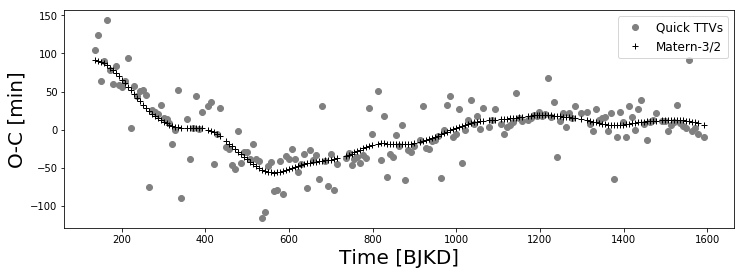

PLANET 1


optimizing logp for variables: [logvar, mean, log_rho, log_sigma]
124it [00:00, 160.18it/s, logp=3.901939e+02]
message: Desired error not necessarily achieved due to precision loss.
logp: 345.8599816949012 -> 390.1939138914171


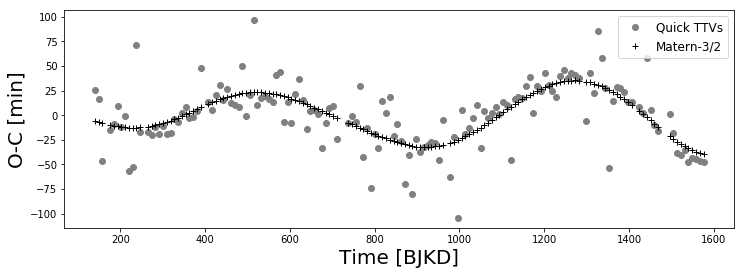

PLANET 2


optimizing logp for variables: [logvar, mean, log_rho, log_sigma]
30it [00:00, 76.25it/s, logp=2.788330e+02] 
message: Optimization terminated successfully.
logp: 199.06793746166568 -> 278.8329845216072


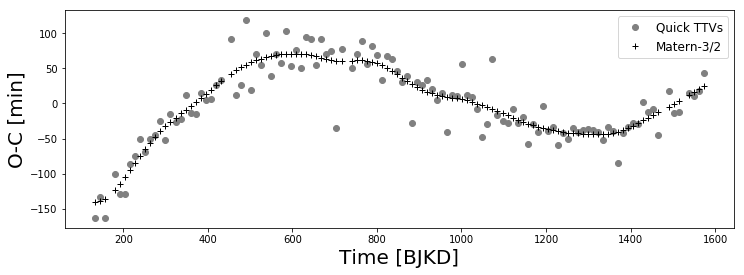

In [10]:
matern_transit_times = []
matern_ephemeris = []

for npl in range(NPL):
    print("PLANET", npl)
    
    # calculate OMC
    xtime = np.copy(quick_ephemeris[npl])
    yomc = quick_transit_times[npl] - quick_ephemeris[npl]

    
    # set up a GP using a Matern-3/2 kernel
    with pm.Model() as matern_model:

        # build the kernel 
        log_sigma = pm.Normal("log_sigma", mu=np.log(np.std(yomc)), sd=10)
        log_rho = pm.Normal("log_rho", mu=np.log(xtime[1]-xtime[0]), sd=10)

        kernel = exo.gp.terms.Matern32Term(log_sigma=log_sigma, log_rho=log_rho)

        # nusiance parameters
        mean = pm.Normal("mean", mu=np.mean(yomc), sd=10)
        logvar = pm.Normal("logvar", mu=np.log(np.var(yomc)), sd=10)

        # here's the GP
        gp = exo.gp.GP(kernel, xtime, T.exp(logvar)*T.ones(len(xtime)))

        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential("obs", gp.log_likelihood(yomc - mean))

        # track GP prediction
        gp_pred = pm.Deterministic("gp_pred", gp.predict(xtime))
        
        
    # find the MAP solution
    with matern_model:
        matern_map = exo.optimize(start=matern_model.test_point)

    matern_transit_times.append(xtime + matern_map["mean"] + matern_map["gp_pred"])
    pfit = np.polyfit(transit_inds[npl], matern_transit_times[npl], 1)
    matern_ephemeris.append(np.polyval(pfit, transit_inds[npl]))
    
    
    
    # plot the results
    plt.figure(figsize=(12,4))
    plt.plot(xtime, yomc*24*60, 'o', c="grey", label="Quick TTVs")
    plt.plot(matern_ephemeris[npl], (matern_transit_times[npl]-matern_ephemeris[npl])*24*60, "k+", label="Matern-3/2")
    plt.xlabel("Time [BJKD]", fontsize=20)
    plt.ylabel("O-C [min]", fontsize=20)
    plt.legend(fontsize=12)
    plt.show()

# Determine TTV initialization settings

In [11]:
# get estimate of ttv amplitdue and a reasonable buffer
ttv_amps   = np.zeros(NPL)
ttv_buffer = np.zeros(NPL)

for npl in range(NPL):
    # estimate TTV amplitude
    ttv_amps[npl] = astropy.stats.mad_std(quick_transit_times[npl] - quick_ephemeris[npl])

    # based on scatter in independent times, set threshold so not even one outlier is expected
    N   = len(transit_inds[npl])
    eta = np.max([3., stats.norm.interval((N-1)/N)[1]])

    ttv_buffer[npl] = eta*ttv_amps[npl]

In [12]:
# determine the time baseline
time_min = []
time_max = []

try:
    time_min.append(sc.time.min())
    time_max.append(sc.time.max()) 
except:
    pass


try:
    time_min.append(lc.time.min())
    time_max.append(lc.time.max())     
except:
    pass
    
    
TIME_START = np.min(time_min) - 0.5*PERIODS.max()
TIME_END   = np.max(time_max) + 0.5*PERIODS.max()


# put epochs in range (TIME_START, TIME_START + PERIOD)
for npl in range(NPL):
    if EPOCHS[npl] < TIME_START:
        adj = 1 + (TIME_START - EPOCHS[npl])//PERIODS[npl]
        EPOCHS[npl] += adj*PERIODS[npl]        
        
    if EPOCHS[npl] > (TIME_START + PERIODS[npl]):
        adj = (EPOCHS[npl] - TIME_START)//PERIODS[npl]
        EPOCHS[npl] -= adj*PERIODS[npl]

# Set up GP

In [13]:
# Read in noise model GP priors
gp_percs = []

for z in range(4):
    try:
        fname_in = NOISE_DIR + TARGET + '_shoterm_gp_priors_{0}.txt'.format(z)

        with open(fname_in) as infile:
            gp_percs.append(json.load(infile))

    except:
        gp_percs.append(None)

# Read in quarter-by-quarter variances
var_by_quarter = np.genfromtxt(NOISE_DIR + TARGET + '_var_by_quarter.txt')[:,1]

In [14]:
all_logSw4 = []
for z in range(4):
    try:
        perc = np.array(gp_percs[z]["percentiles"])
        
        all_logSw4.append(np.array(gp_percs[z]["logSw4"])[perc == 50.0][0])
        
    except:
        pass

In [15]:
gp_priors = []

for z in range(4):
    if gp_percs[z] is not None:
        # set GP priors baed on outputs of alderaan.detrend_and_estimate_noise
        # expected for any season with short cadence data
        gpi = {}

        for k in gp_percs[z].keys():
            if k != "percentiles":
                perc = np.array(gp_percs[z]['percentiles'])

                med = np.array(gp_percs[z][k])[perc == 50.0][0]
                err1 = np.array(gp_percs[z][k])[perc == 84.1][0]
                err2 = np.array(gp_percs[z][k])[perc == 15.9][0]

                dev = np.sqrt((err1-med)**2/2 + (err2-med)**2/2)

                gpi[k] = (med, dev)

        gp_priors.append(gpi)
        
    else:
        # these are dummy values that effectively create a zero-amplitude kernel
        # expected for any season with only long cadence data
        gpi = {}
        gpi['logw0'] = [np.log(2*pi/(5*DURS.max()))]
        gpi['logSw4'] = [-40.]
        gpi['logQ'] = [1/np.sqrt(2)]
        
        gp_priors.append(gpi)

# Grab the relevant data and starting transit parameters

In [16]:
# grab data near transits for each quarter
all_time = []
all_flux = []
all_mask = []
all_dtype = []


if sc is not None:
    for q in range(18):
        if np.isin(q, sc.quarter)*np.isin(q, lc.quarter):
            raise ValueError("Double counting data in both short and long cadence")


        elif np.isin(q, sc.quarter):
            use = (sc.mask.sum(axis=0) > 0)*(sc.quarter == q)

            if np.sum(use) > 45:
                all_time.append(sc.time[use])
                all_flux.append(sc.flux[use])
                all_mask.append(sc.mask[:,use])
                all_dtype.append('short')
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_mask.append(None)
                all_dtype.append('none')


        elif np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)
            
            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_mask.append(lc.mask[:,use])
                all_dtype.append('long')
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_mask.append(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_mask.append(None)
            all_dtype.append('none')
            
else:
    for q in range(18):
        if np.isin(q, lc.quarter):
            use = (lc.mask.sum(axis=0) > 0)*(lc.quarter == q)

            if np.sum(use) > 3:
                all_time.append(lc.time[use])
                all_flux.append(lc.flux[use])
                all_mask.append(lc.mask[:,use])
                all_dtype.append('long')
                
            else:
                all_time.append(None)
                all_flux.append(None)
                all_maskappend(None)
                all_dtype.append('none')


        else:
            all_time.append(None)
            all_flux.append(None)
            all_mask.append(None)
            all_dtype.append('none')



# check which quarters have data
good = (np.array(all_dtype) == 'short') + (np.array(all_dtype) == 'long')
quarters = np.arange(18)[good]
nq = len(quarters)

lc_quarters = np.arange(18)[np.array(all_dtype) == 'long']
sc_quarters = np.arange(18)[np.array(all_dtype) == 'short']


# expand var_by_quarter to have None for missing quarters
vbq_all = [None]*18

for j, q in enumerate(quarters):
    vbq_all[q] = var_by_quarter[j]
    
vbq_all = np.asarray(vbq_all, dtype="float")

In [17]:
print('')
print('cumulative runtime = ', int(timer() - global_start_time), 's')
print('')


cumulative runtime =  23 s



# (3) Fit a transit model with fixed transit times

In [18]:
print('\n(3) Fitting FIXED TTV model')


(3) Fitting FIXED TTV model


In [19]:
with pm.Model() as fixed_model:
    # stellar parameters (limb darkening using Kipping 2013)
    u = exo.distributions.QuadLimbDark('u', testval=np.array([U1,U2]))

    Rstar = pm.Bound(pm.Normal, lower=RSTAR-3*RSTAR_ERR, upper=RSTAR+3*RSTAR_ERR)('Rstar', mu=RSTAR, sd=RSTAR_ERR)
    Mstar = pm.Bound(pm.Normal, lower=MSTAR-3*MSTAR_ERR, upper=MSTAR+3*MSTAR_ERR)('Mstar', mu=MSTAR, sd=MSTAR_ERR)
    
    # planetary parameters (impact parameter using Espinoza 2018)
    logr = pm.Uniform('logr', lower=np.log(0.0003), upper=np.log(0.3), testval=np.log(RADII), shape=NPL)
    rp   = pm.Deterministic('rp', T.exp(logr))
    b    = exo.distributions.ImpactParameter('b', ror=rp/Rstar, testval=IMPACTS, shape=NPL)


    # set up stellar model and planetary orbit
    exoSLC = exo.StarryLightCurve(u)
    orbit  = exo.orbits.TTVOrbit(transit_times=matern_transit_times, transit_inds=transit_inds, \
                                 b=b, r_star=Rstar, m_star=Mstar)

    
    # track period and epoch
    T0 = pm.Deterministic('T0', orbit.t0)
    P  = pm.Deterministic('P', orbit.period)
    
    
    # build the GP kernel using a different noise model for each season
    logSw4 = [None]*4
    logw0  = [None]*4
    logQ   = [None]*4
    kernel = [None]*4
    
    for i in range(4):
        gpi = gp_priors[i]

        # here's the single low-frequency term
        logSw4[i] = gpi['logSw4'][0]
        logw0[i] = gpi['logw0'][0]
        logQ[i] = gpi['logQ'][0]

        kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
    
    
    # nuissance parameters (one mean flux; variance by quarter)
    flux0 = pm.Normal('flux0', mu=np.ones(nq), sd=np.sqrt(var_by_quarter)/4, shape=nq)
    logvar = pm.Normal('logvar', mu=np.log(var_by_quarter), sd=np.log(4)*np.ones(nq), shape=nq)
   

    # now evaluate the model for each quarter
    light_curves       = [None]*nq
    summed_light_curve = [None]*nq
    model_flux         = [None]*nq
    
    gp      = [None]*nq
    gp_pred = [None]*nq
    
    
    for j, q in enumerate(quarters):
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
        # calculate light curves
        light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp, t=all_time[q], oversample=oversample)
        summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(all_time[q]))
        model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
        
        # here's the GP (w/ kernel by season)
        gp[j] = exo.gp.GP(kernel[q%4], all_time[q], T.exp(logvar[j])*T.ones(len(all_time[q])))


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(all_flux[q] - model_flux[j]))


        # track GP prediction
        #gp_pred[j] = pm.Deterministic('gp_pred_{0}'.format(j), gp[j].predict())

In [20]:
with fixed_model:
    fixed_map = exo.optimize(start=fixed_model.test_point, vars=[flux0, logvar])   
    fixed_map = exo.optimize(start=fixed_map, vars=[b])
    fixed_map = exo.optimize(start=fixed_map, vars=[u, Mstar])
    fixed_map = exo.optimize(start=fixed_map)

optimizing logp for variables: [logvar, flux0]
155it [00:12, 12.61it/s, logp=6.181708e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 618131.0557968316 -> 618170.8443592438
optimizing logp for variables: [b, logr, Rstar]
168it [00:11, 14.10it/s, logp=6.183158e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 618170.8443592438 -> 618315.7626979206
optimizing logp for variables: [Mstar, u]
12it [00:00, 14.60it/s, logp=6.183166e+05]
message: Optimization terminated successfully.
logp: 618315.7626979206 -> 618316.6178144445
optimizing logp for variables: [logvar, flux0, b, logr, Mstar, Rstar, u]
185it [00:17, 10.64it/s, logp=6.183197e+05]
message: Desired error not necessarily achieved due to precision loss.
logp: 618316.6178144445 -> 618319.7378175468


# Set fixed values for star and planet parameters

In [21]:
# grab star and planet parameters for that sample
u = fixed_map["u"]

Rstar = fixed_map["Rstar"]
Mstar = fixed_map["Mstar"]

rp = np.exp(fixed_map["logr"])
b  = fixed_map["b"]

periods = fixed_map["P"]
epochs = fixed_map["T0"]

sma = get_sma(periods, Mstar)
durs = get_dur_tot(periods, rp, Rstar, b, sma)

# Identify overlapping transits

In [22]:
dur_max = np.max(durs)
overlap = []

for i in range(NPL):
    overlap.append(np.zeros(len(quick_transit_times[i]), dtype='bool'))
    
    for j in range(NPL):
        if i != j:
            for tt in quick_transit_times[j]:
                overlap[i] += np.abs(quick_transit_times[i] - tt) < dur_max

In [23]:
thresh = np.zeros(len(quarters)+1)
thresh[0] = np.min(np.hstack([lc.time, sc.time]))

for j, q in enumerate(quarters):
    thresh[j+1] = np.max(np.hstack([lc.time[lc.quarter==q],sc.time[sc.quarter==q]]))
    
thresh[0] -= 1.0
thresh[-1] += 1.0

transit_quarter = [None]*NPL

for npl in range(NPL):
    qtt = quick_transit_times[npl]
    transit_quarter[npl] = np.zeros(len(qtt), dtype='int')

    for j, q in enumerate(quarters):
        transit_quarter[npl][(qtt >= thresh[j])*(qtt<thresh[j+1])] = q

In [28]:
lc_quarters

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [27]:
sc_quarters

array([12, 13, 14, 15, 16, 17])

# Count up transits and break into subgroups if $N_{trans} > 16$ 

In [ ]:
# fit at most MAX_GROUP_SIZE transits at a time
MAX_GROUP_SIZE = 20

ngroups = []
tts_group = []

for npl in range(NPL):
    num_trans_total = len(overlap[npl])
    num_trans_nonoverlap = (np.sum(~overlap[npl]))
    
    ngroups.append(int(np.ceil(num_trans_nonoverlap/MAX_GROUP_SIZE)))
    
    groupsize = int(np.ceil(num_trans_nonoverlap/ngroups[npl]))
    r = np.repeat(np.arange(1,ngroups[npl]+1), groupsize)
    
    tg = np.zeros(num_trans_total, dtype="int")
    tg[~overlap[npl]] = np.random.choice(r, size=num_trans_nonoverlap, replace=False)
    
    tts_group.append(tg)

In [ ]:
group_mask = [None]*18

for q in range(18):
    if all_mask[q] is not None:        
        t_ = all_time[q]
        m_ = np.array(all_mask[q].copy(), dtype="int")
    
        for npl in range(NPL):
            for i, t0 in enumerate(quick_transit_times[npl]):
                m_[npl][np.abs(t_-t0)/durs[npl] < 3.0] = tts_group[npl][i]

        group_mask[q] = np.copy(m_)

        
for npl in range(NPL):
    plt.figure(figsize=(20,3))
    
    for j, q in enumerate(quarters):        
        t_ = all_time[q]
        f_ = all_flux[q]
        m_ = group_mask[q][npl]
        
        for ng in range(1,ngroups[npl]+1):
            plt.plot(t_[m_==ng], f_[m_==ng], ".", c="C{0}".format(ng-1))
        
    plt.show()

# (4) Fit independent transit times

In [26]:
tts_chains = []
offset_chains = []

for npl in range(NPL):
    for g in range(1,ngroups[npl]+1):
        print("\nPLANET {0}, GROUP {1}".format(npl,g))
        
        # identify which quarters and which_seasons have data
        use = tts_group[npl] == g
        
        wq = np.unique(transit_quarter[npl][use])
        ws = np.unique(wq % 4)
                        
        # grab transit times
        fixed_tts = np.copy(shape_transit_times[npl][use])
        fixed_inds = np.copy(transit_inds[npl][use])
        
        print(np.sum(use), "transits")
        print("quarters:", wq)

        # now build the model
        with pm.Model() as indep_model:
            # transit times
            tt_offset = pm.StudentT('tt_offset', nu=2, shape=len(fixed_tts), testval=np.zeros(len(fixed_tts)))
            transit_times = pm.Deterministic('tts', fixed_tts + tt_offset*ttv_amps[npl])
            
            # set up stellar model and planetary orbit
            exoSLC = exo.StarryLightCurve(u)
            orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[fixed_inds], 
                                         b=b[npl], r_star=Rstar, m_star=Mstar)

            # track period and epoch
            T0 = pm.Deterministic('T0', orbit.t0)
            P  = pm.Deterministic('P', orbit.period)
            
            # nuissance parameters (one mean flux; variance by quarter)
            flux0 = pm.Normal('flux0', mu=np.ones(len(wq)), sd=np.sqrt(vbq_all[wq])/4, shape=len(wq))
            logvar = pm.Normal('logvar', mu=np.log(vbq_all[wq]), sd=np.log(4)*np.ones(len(wq)), shape=len(wq))

            
            # build the GP kernel using a different noise model for each season
            logSw4 = [None]*4
            logw0  = [None]*4
            logQ   = [None]*4
            kernel = [None]*4

            for i in range(4):
                if np.isin(i, ws):
                    gpi = gp_priors[i]              

                    logSw4[i] = gpi['logSw4'][0]
                    logw0[i] = gpi['logw0'][0]
                    logQ[i] = gpi['logQ'][0]

                    kernel[i] = exo.gp.terms.SHOTerm(log_Sw4=logSw4[i], log_w0=logw0[i], log_Q=logQ[i])
                
                else:
                    kernel[i] = None
            
            
            # now evaluate the model for each quarter
            light_curves       = [None]*len(wq)
            summed_light_curve = [None]*len(wq)
            model_flux         = [None]*len(wq)
            
            gp = [None]*len(wq)
            

            for j, q in enumerate(wq):
                # here's the data
                t_ = all_time[q]
                f_ = all_flux[q]
                m_ = group_mask[q][npl] == g
                
                if np.sum(m_) == 0:
                    raise ValueError("Got unexpected empty data array")

                # set oversampling factor
                if all_dtype[q] == 'short':
                    oversample = 1
                elif all_dtype[q] == 'long':
                    oversample = 15

                # calculate light curves
                light_curves[j] = exoSLC.get_light_curve(orbit=orbit, r=rp[npl], t=t_[m_], oversample=oversample)
                summed_light_curve[j] = pm.math.sum(light_curves[j], axis=-1) + flux0[j]*T.ones(len(t_[m_]))
                model_flux[j] = pm.Deterministic('model_flux_{0}'.format(j), summed_light_curve[j])
                
                # here's the GP (w/ kernel by season)
                gp[j] = exo.gp.GP(kernel[q%4], t_[m_], T.exp(logvar[j])*T.ones(len(t_[m_])))
                
                
                # add custom potential (log-prob fxn) with the GP likelihood
                pm.Potential('obs_{0}'.format(j), gp[j].log_likelihood(f_[m_] - model_flux[j]))
                
                
        with indep_model:
            indep_map = exo.optimize(start=indep_model.test_point)
            
            
        tts_chains.append(np.copy(np.array(indep_map['tts'])))
        offset_chains.append(np.copy(np.array(indep_map['tt_offset'])))

                
        # sample from the posterior
        #with indep_model:
        #    indep_trace = pm.sample(tune=5, draws=3, start=indep_model.test_point, chains=2,
        #                            step=exo.get_dense_nuts_step(target_accept=0.9))

        #tts_chains.append(np.copy(np.array(indep_trace['tts'])))
        #offset_chains.append(np.copy(np.array(indep_trace['tt_offset'])))


PLANET 0, GROUP 1
14 transits
quarters: [ 2  5  6  7 10 11 13 16]


optimizing logp for variables: [logvar, flux0, tt_offset]
210it [00:03, 53.70it/s, logp=1.556784e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 15562.692324234893 -> 15567.838573098295



PLANET 0, GROUP 2
16 transits
quarters: [ 1  3  5  6  7 11 12 13 14 15 16]


optimizing logp for variables: [logvar, flux0, tt_offset]
88it [00:05, 15.27it/s, logp=3.774882e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 37718.13814751551 -> 37748.82128000279



PLANET 0, GROUP 3
15 transits
quarters: [ 2  3  4  5  6  8  9 10 11 13 14 15 17]


optimizing logp for variables: [logvar, flux0, tt_offset]
251it [00:07, 34.90it/s, logp=2.457645e+04] 
message: Desired error not necessarily achieved due to precision loss.
logp: 24560.65101525584 -> 24576.449234078053



PLANET 0, GROUP 4
16 transits
quarters: [ 1  5  6  8 10 12 14 15 16 17]


ValueError: Got unexpected empty data array

In [ ]:
# make primary HDU
primary_hdu = pyfits.PrimaryHDU()
header = primary_hdu.header
header['TARGET'] = TARGET
primary_hdu.header = header
    
# add it to HDU list
indep_hdulist = []
indep_hdulist.append(primary_hdu)


# grab all samples from trace
i = 0

for npl in range(NPL):
    combo_tts = []
    combo_offset = []
    combo_groupno = []

    for j in range(ngroups[npl]):
        combo_tts.append(tts_chains[i])
        combo_offset.append(offset_chains[i])
        combo_groupno.append((j+1)*np.ones(tts_chains[i].shape[1], dtype="int"))
        
        i += 1
        
    combo_tts = np.hstack(combo_tts)
    combo_offset = np.hstack(combo_offset)
    combo_groupno = np.hstack(combo_groupno)

    order = np.argsort(np.median(combo_tts,0))

    combo_tts = combo_tts[:,order]
    combo_offset = combo_offset[:,order]
    combo_groupno = combo_groupno[order]
    
    
    # add to HDUList
    indep_hdulist.append(pyfits.ImageHDU(combo_tts, name='TTS_{0}'.format(npl)))
    indep_hdulist.append(pyfits.ImageHDU(combo_offset, name='OFFSET_{0}'.format(npl)))
    indep_hdulist.append(pyfits.ImageHDU(combo_groupno, name='GROUP_{0}'.format(npl)))

    
indep_hdulist = pyfits.HDUList(indep_hdulist)
indep_hdulist.writeto(TRACE_DIR + TARGET + '_indep_ttvs.fits', overwrite=True)

print('TOTAL RUNTIME = %.2f min' %((timer()-global_start_time)/60))

# Fit INDEPENDENT TTVs on a quarter-by-quarter basis

In [ ]:
tts_chains = []
offset_chains = []

for npl in range(NPL):
    tts_chains.append([])
    offset_chains.append([])

In [ ]:
tts_chains = []
offset_chains = []

for npl in range(NPL):
    tts_chains.append([])
    offset_chains.append([])

for j, q in enumerate(quarters):
    #print("\nQUARTER {0}".format(q))

    fixed_tts = []
    fixed_inds = []
    
    for npl in range(NPL):
        use = transit_quarter[npl] == q
        
        fixed_tts.append(matern_transit_times[npl][use])
        fixed_inds.append(transit_inds[npl][use])
        
        
    # build the model
    with pm.Model() as indep_model:
        
        # determine the transit times
        tt_offset = []
        transit_times = []
        
        for npl in range(NPL):
            tt_offset.append(pm.StudentT('tt_offset_{0}'.format(npl), nu=2, shape=len(fixed_tts[npl])))
            transit_times.append(pm.Deterministic('tts_{0}'.format(npl), fixed_tts[npl] + tt_offset[npl]*ttv_amps[npl]))
            
            
        # set up stellar model and planetary orbit
        exoSLC = exo.StarryLightCurve(u)
        orbit  = exo.orbits.TTVOrbit(transit_times=[transit_times], transit_inds=[fixed_inds], 
                                     b=b[npl], r_star=Rstar, m_star=Mstar)

        # track period and epoch
        T0 = pm.Deterministic('T0', orbit.t0)
        P  = pm.Deterministic('P', orbit.period)
        
        # nuissance parameters
        flux0 = pm.Normal('flux0', mu=0, sd = np.sqrt(vbq_all[q])/4)
        logvar = pm.Normal('logvar', mu=np.log(vbq_all[q]), sd=np.log(4))
        
        # build the GP kernel
        logSw4 = gpi['logSw4'][q%4]
        logw0 = gpi['logw0'][q%4]
        logQ = gpi['logQ'][q%4]
        
        kernel = exo.gp.terms.SHOTerm(log_Sw4=logSw4, log_w0=logw0, log_Q=logQ)
        
        # grab the data
        t_ = all_time[q]
        f_ = all_flux[q]
        m_ = group_mask[q]
        
        
        # set oversampling factor
        if all_dtype[q] == 'short':
            oversample = 1
        elif all_dtype[q] == 'long':
            oversample = 15
            
            
        # calculate light curves
        light_curves = exoSLC.get_light_curve(orbit=orbit, r=rp, t=t_[m_], oversample=oversample)
        summed_light_curve = pm.math.sum(light_curves, axis=-1) + flux0*T.ones(len(t_[m_]))
        model_flux = pm.Deterministic('model_flux'.format(j), summed_light_curve)
        
        
        # here's the GP (w/ kernel by season)
        gp = exo.gp.GP(kernel, t_[m_], T.exp(logvar)*T.ones(len(t_[m_])))


        # add custom potential (log-prob fxn) with the GP likelihood
        pm.Potential('obs', gp.log_likelihood(f_[m_] - model_flux))

In [ ]:
fixed_tts

In [ ]:
tt_offset[0]